<a href="https://colab.research.google.com/github/urieliram/statistical/blob/main/Tarea15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [49]:
pip install dtw-python

In [50]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin
from statsmodels.graphics.tsaplots import plot_acf
import pandas as pd
import statsmodels.api as sm
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
import math
from math import sqrt
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV, LarsCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from dtw import *


In [51]:
CYAN = '#76ced6' ; LILA = '#777bd4'; VERDE='#17cb49'; LETRASNARA='#ff8000'; AZUL='#168fff'; OTROAZUL = "b-"; ROJO= "r-";
def print_serie(serie_,title_,ytitle_,xtitle_,dot_,namefile_):
    fig, ax1 = plt.subplots(figsize=(7,4))
    plt.title(title_,fontsize='x-large',color=LETRASNARA)
    ax1.set_xlabel(xtitle_, color=LETRASNARA, fontsize='large')
    ax1.set_ylabel(ytitle_, color=LETRASNARA, fontsize='large')
    plt.tick_params(colors = LETRASNARA, which='both')
    ax1.spines['bottom'].set_color(LETRASNARA)
    ax1.spines['top'   ].set_color(LETRASNARA) 
    ax1.spines['right' ].set_color(LETRASNARA)
    ax1.spines['left'  ].set_color(LETRASNARA)    
    for p in serie_:
        if dot_== True:
           plt.plot(p,alpha=0.4, linestyle='dashed', linewidth=3)
        else:
           plt.plot(p,alpha=0.4)                
    plt.savefig(namefile_, transparent=True)         
    plt.show()

In [52]:
## Encuentra los vecinos más cercanos
def get_neighbors(train, test_row, num_neighbors, typedist='euclidean'):
  
    distances = list()

    for train_row in train:
        if typedist == 'dtw':
            dist = dtw(test_row, train_row)
        else:
            dist = euclidean(test_row, train_row)
        distances.append((train_row, dist))
    distances.sort(key=lambda tup: tup[1])

    neighbors = list()

    for i in range(num_neighbors):
        neighbors.append(distances[i][0])
    return neighbors

## Calcula distancia euclidiana
def euclidean(neig1, neig2):
	  distance = 0.0
	  for i in range(len(neig1)):
		    distance += (neig1[i] - neig2[i])**2
	  return sqrt(distance)

In [53]:
#https://drive.google.com/drive/folders/1Gj3XK9kM-lE18uBMe3qrZOGEm8yAI8i9
#https://www.codegrepper.com/code-examples/python/how+to+read+csv+file+from+google+drive+on+google+colab+
path        = 'https://drive.google.com/uc?export=download&id=' 
URL_Demanda = 'https://drive.google.com/file/d/1xcpXDTE7H6EBMLOkic5lq-lzSwiLG2ZS/view?usp=sharing'
df_Demanda  = pd.read_csv(path + URL_Demanda .split('/')[-2], usecols=[0] ) #names=['CLVUNI','TYPE','NODE'], usecols=[1,2,3,4,5,6,], 1,2,3,4,5,6,7,8,9,10,11,12,13,15,
df_Demanda.dropna(inplace=True)
serie = df_Demanda.to_numpy()

serie = StandardScaler().fit_transform(serie)

In [84]:
def analogo_knn(serie,v,k=10,tol=0.8,typedist='euclidian',typereg='OLS'):    
#    v       : tamanio de la ventana
#    k       : número de vecinos a buscar k
#    tol     : tolerancia de tamaño de ventanas para seleccion de vecinos
#    typedist: medida de distancia, 'dtw' o 'euclidian' o 'pearson'

    vecindario    = []         ## vecindario completo
    vecindario_b  = [] 
    distances     = []
    n             = len(serie) ## longitud total de la serie
    #print(serie[n-v:n],'**')  ## imprime la última ventana
    t_o = time.time() 

    ## PASO 1: Selección de las ventanas de mayor correlación
    ## Se calcula la distancia euclidiana entre todos los vecinos.
    for i in range(n-2*v+1):
        if  typedist=='euclidian':
            dist = euclidean(serie[n-v:n],serie[i:i+v])
        else:
            dist = dtw(serie[n-v:n], serie[i:i+v]).distance
        distances.append((i, dist))
        #print(serie[n-v:n],serie[i:i+v],i, dist)

    ## Se ordena el vecindario por distancia de menor a mayor y se guardan las posiciones.
    distances.sort(key=lambda tup: tup[1])
    neighbors  = []
    neighbors2 = []
    position   = []

    ## Se escogen los k vecinos mas cercanos y guardamos las posiciones.
    i = 0
    for pos, dis in distances:
        #print(serie[pos:pos+v],dis,pos)

        if i==0:      
            position.append(pos)   
            neighbors.append(serie[pos:pos+v])
            neighbors2.append(serie[pos+v:pos+2*v])
        else:
            bandera = True
            for p in position:
                if (abs(pos - p) < tol*v):
                    bandera = False
                    i = i - 1
                    break
            if bandera == True:
                #print(pos,p)
                position.append(pos)   
                neighbors.append(serie[pos:pos+v])
                neighbors2.append(serie[pos+v:pos+2*v])
                bandera = False
        i = i + 1
        if i == k:
            break

    ## Convertimos a numpy.  
    neighbors  = np.array(neighbors)
    neighbors2 = np.array(neighbors2)
    print('position',position)    ## posición de los k vecinos mas cercanos.
    #print(neighbors)             ## k vecinos mas cercanos.
    #print(neighbors2)            ## ventana de datos inmediata posterior a los k vecinos mas cercanos.

    print_serie(neighbors, 'KNN - X ','','time', False,'fig_1')
    print_serie(neighbors2,'KNN - X2','','time', False,'fig_2')

    t_sel = time.time() - t_o

    ## PASO 1: Regresión entre los vecinos 'X' y la última ventana 'Y' 

    ##Definimos nuestros regresores 
    XX   = (neighbors.T).tolist()
    X_2  = (neighbors2.T).tolist()
    yy   = (serie[n-v:n]).tolist()

    y = []
    y_real = []

    for i in yy:
        y.append(i[0])

#    for i in yy_real:
#        y_real.append(i[0])

    X = []
    X = XX[0]

    model   = sm.OLS(y, X)
    results = model.fit()
    result_prediction = results.predict(X_2)
    #print(result_prediction)
    print(results.summary())

    ## Se ordenan los valores pi y se selecciona el más grande.
    i = 0
    pvalues = []
    for pi in results.pvalues:
        pvalues.append((i,pi))
        i = i + 1
    pvalues.sort(key=lambda tup: tup[1]) ## ordena por pi HAY UN ERROR AQUI!!!!!!! SE ESTÁ ESCOGIENDO EL PI MAS CHICO , NO EL MAS GRANDE !!!!!!!!!
    print(pvalues)
    (i, pi) = pvalues[0] #len(pvalues)-1
    print('pi_0',pi)

    ## Proceso de regresión OLS con stepwise
    while pi > 0.01:
        #print( X )
        X   = sm.add_constant(X)
        X_2 = sm.add_constant(X_2) 
        print('Retiramos regresor X' + str(i))
        X   = np.delete(arr=X,   obj=i+0, axis=1)
        X_2 = np.delete(arr=X_2, obj=i+0, axis=1)   
        #print( X )
        model   = sm.OLS(y, X)
        results = model.fit()

        ## Se ordenan los valores p y se selecciona el más grande
        i = 0
        pvalues = []
        for pi in results.pvalues:
            pvalues.append((i,pi))
            i = i + 1
        pvalues.sort(key=lambda tup: tup[1])
        (i, pi) = pvalues[0] #len(pvalues)-1## ordena por pi HAY UN ERROR AQUI!!!!!!! SE ESTÁ ESCOGIENDO EL PI MAS CHICO , NO EL MAS GRANDE !!!!!!!!!
        print(pi)

    result_prediction   = results.predict(X)
    result_prediction_2 = results.predict(X_2)
    print(results.summary())

    result_prediction   = result_prediction[0]
    result_prediction_2 = result_prediction_2[0]

    
    t_reg = t_sel - time.time() 

    return result_prediction_2, t_sel, t_reg


position [22179, 20740, 22467, 21892, 22754, 23912, 24197, 20451, 24768, 24485]


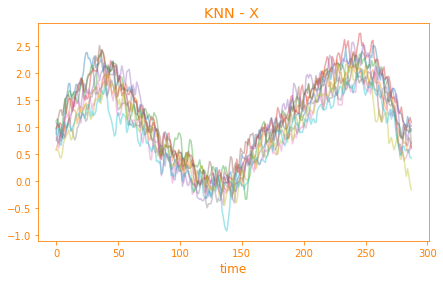

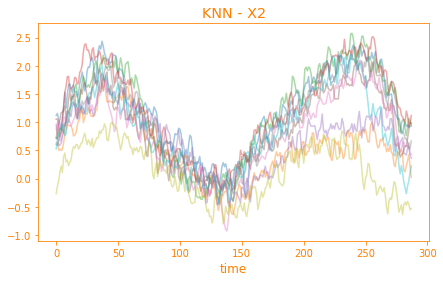

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.978
Model:                            OLS   Adj. R-squared (uncentered):              0.977
Method:                 Least Squares   F-statistic:                              1210.
Date:                Fri, 06 May 2022   Prob (F-statistic):                   1.02e-222
Time:                        22:12:18   Log-Likelihood:                          41.023
No. Observations:                 288   AIC:                                     -62.05
Df Residuals:                     278   BIC:                                     -25.42
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [85]:
#PROBAMOS EL MODELO con la última ventana
x_train = serie[0 : len(serie) - 288]
y_test = serie[len(serie) - 288 : ]
pred, t_sel, t_reg = analogo_knn(x_train,v=288,k=10,tol=0.8,typedist='euclidian',typereg='OLS')
print('t_sel',t_sel)
print('t_reg',t_reg)


In [86]:
# Exactitud del modelo
print('Test MAE OLS + stepwise= ', mean_absolute_error(y_test,pred))

Test MAE OLS + stepwise=  0.3888115238451104


No handles with labels found to put in legend.


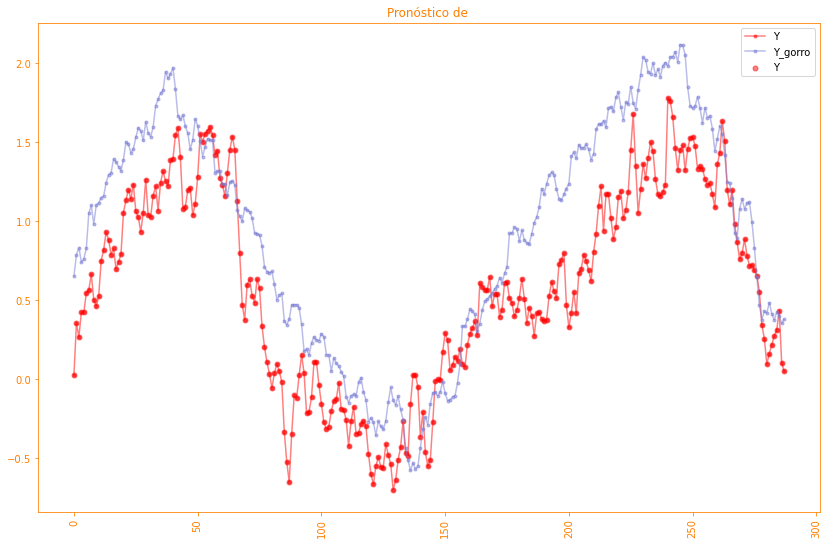

In [79]:
fig  = plt.figure(figsize=(14,9))
axes = fig.add_subplot(1, 1, 1)
#plt.style.use("seaborn-poster")
axes.legend()
CYAN = '#76ced6' ; LILA = '#777bd4'; VERDE='#17cb49'; LETRASNARA ='#ff8000'; AZUL='#168fff';
mytitle = plt.title('Pronóstico de ') # get the title property handler #plt.getp(title_obj)
plt.setp(mytitle,    color=LETRASNARA)                                        #set the color of title to red
axes.xaxis.label.set_color(LETRASNARA)
axes.yaxis.label.set_color(LETRASNARA)
axes.tick_params(colors=LETRASNARA, which='both')

AUX = np.arange( len(y_test) )
plt.scatter( AUX, y_test, s=25,marker='o', color = 'red', label = 'Y', alpha=1/2)
axes.plot  ( y_test ,                '.-' , color = 'red'  , label = 'Y'   ,alpha=1/2)
axes.plot  ( pred ,   '.-' , color = LILA  , label = 'Y_gorro'   ,alpha=1/2)
#axes.plot  ( y_pred_poly,  '.-' , color = VERDE , label = 'SVM poly'   ,alpha=1/2)
#axes.plot  ( y_pred_linear, '.-' , color = AZUL , label = 'SVM linear'   ,alpha=1/2)
#axes.plot  ( y_local_list[1], '.-' , color = VERDE      , label = 'Y_local,k=25'   ,alpha=1/2)
#axes.plot  ( y_local_list[2], '.-' , color = AZUL       , label = 'Y_local,k=35'   ,alpha=1/2)
#axes.plot  ( y_local_list[3], '.-' , color = LILA       , label = 'Y_local,k=50'   ,alpha=1/2)
#axes.plot  ( y_local_list[4], '.-' , color = CYAN       , label = 'Y_local,k=100'  ,alpha=1/2)
#axes.plot  ( y_lineal         , '--' , color = 'red'      , label = 'lineal'       ,alpha=1/2)
#axes.plot ( y      , '.-'  , color = 'red'        , label = 'Y'  ,alpha=1/2)
#axes.plot ( y_local, '.-'  , color = LETRASNARA   , label = 'Y_local'  ,alpha=1/2)
#axes.plot ( xspline[3], yspline[3] , '.-'  , color = VERDE   , label = 'orden=4'  ,alpha=1/2)
#axes.plot ( xspline[4], yspline[4] , '.-'  , color = AZUL   , label = 'orden=5'  ,alpha=1/12)
#plt.scatter( dfx_miss, dfy_miss, marker='x',  s=170 ,  color = 'red' , label = 'perdidos' ,alpha=1)

#plt.axis([0,  600, 7650, 9800])
#plt.axis([100,  200, 7650, 9500])
#plt.axis([400,  500, 7450, 9500])
#plt.axis([-2,  100, 8100, 9600])
#plt.axis([300, 400, 7900, 9500])

axes.spines['bottom'].set_color(LETRASNARA)
axes.spines['top'   ].set_color(LETRASNARA) 
axes.spines['right' ].set_color(LETRASNARA)
axes.spines['left'  ].set_color(LETRASNARA)
plt.legend()  
plt.xticks(rotation=90)
plt.savefig('fig_t13_aportaciones_prono3.png', transparent=True)
plt.show()